In [1]:
import os
os.chdir('../')

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.train_probes import get_hyperparams_combinations
from src.XAI.concepts import concept_instances

In [3]:
hyperparam_ranges = {
    'lr': (0.001,),
    'batch_size': (32,),
    'lambda_l1': (0.001,),
    'patience': (10,),
    'epochs': (300,)
}
hyperparams = get_hyperparams_combinations(hyperparam_ranges)

In [4]:
env_steps = Concept.load_concept_data()
model_path = 'runs/20240317-112025_task_0'

def get_models(model_path):
    models = os.listdir(model_path)
    # Number of steps from file name
    models = [(f, int(f.split('_')[1].replace('.pt',''))) for f in models if f.endswith(".pt")]
    # Sort on the number of steps
    models.sort(key=lambda x: x[1])
    return models

models = get_models(model_path)

In [5]:
def get_scores(concept, models, layers, hyperparams, load=False):
    input_score = None
    if load:
        # Load pkl file with scores
        files = os.listdir(concept.folder_path)
        if files:
            filename = [f for f in files if f.startswith('evolution_')][0]
            input_score = float(filename.split('_')[-1].split('.pkl')[0])

            with open(os.path.join(concept.folder_path, filename), 'rb') as f:
                scores = pickle.load(f)
            print(f'Loaded scores from {filename}')
            return scores, input_score
    
    concept.prepare_data(env_steps, max_size=10000)
    scores = {'x': None, 'y': None, 'z': None}
    train_steps = [m[1] for m in models]
    x, y = np.meshgrid(train_steps, layers)
    scores['x'] = x
    scores['y'] = y
    scores['z'] = np.zeros((len(layers), len(train_steps)))

    for step_index, step in enumerate(train_steps):
        path = os.path.join(model_path, f'model_{step}.pt')
        model = QNetwork(model_path=path)
        if input_score is None:
            layer_probes, layer_info, best_hyperparams = train_probes(model, concept, hyperparams, [-1] + layers)
            input_score = layer_info[-1]['test_score'][-1]

            # Update evolution_path and filename with actual input_score
            evolution_filename = f'evolution_{input_score}.pkl'
            evolution_path = os.path.join(concept.folder_path, evolution_filename)
        else:
            layer_probes, layer_info, best_hyperparams = train_probes(model, concept, hyperparams, layers)
        
        for layer_index, layer in enumerate(layers):
            scores['z'][layer_index][step_index] = layer_info[layer]['test_score'][-1]
    
    # Save the scores along with the new filename including input score
    with open(evolution_path, 'wb') as f:
        pickle.dump(scores, f)

    return scores, input_score

In [6]:
# Adds input_score as -1 layer instead of plane
def plot_evolution(concept, scores, input_score):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.text2D(0.5, 0.9, f'{concept.name}', transform=ax.transAxes, ha='center', fontsize=20)
    ax.view_init(elev=25, azim=200)

    # Create a new layer "-1" at the beginning with scores based on input_score
    min_y = np.min(scores['y'])  # Find the current minimum layer
    new_layer_y = min_y - 1  # This will be our "-1" layer
    new_layer = {'x': scores['x'][0, :], 'y': np.full(scores['y'][0, :].shape, new_layer_y), 'z': np.full(scores['z'][0, :].shape, input_score)}

    # Append the new layer to the beginning of scores
    scores['y'] = np.vstack((new_layer['y'], scores['y']))
    scores['x'] = np.vstack((new_layer['x'], scores['x']))
    scores['z'] = np.vstack((new_layer['z'], scores['z']))

    ax.plot_surface(scores['x'], scores['y'], np.maximum(0, scores['z']), vmin=0, vmax=1, cmap='plasma')
    
    ax.set_xlabel('Training steps', fontsize=12, labelpad=10)
    train_steps = np.unique(scores['x'])
    labeled_train_steps = train_steps[::4]
    ax.set_xticks(labeled_train_steps)
    ax.set_xticklabels([f'{step//1000000}m' for step in labeled_train_steps])

    ax.set_ylabel('Layer', fontsize=12, labelpad=10)
    ax.set_yticks(np.unique(scores['y']))
    ytick_labels = [str(int(y)) if y != new_layer_y else '-1' for y in np.unique(scores['y'])]
    ax.set_yticklabels(ytick_labels)

    ax.set_zlabel('Score', fontsize=12)
    ax.set_zlim(0, 1)

    plt.savefig(f'{concept.folder_path}/evolution.png')
    plt.show()


Loaded scores from evolution_0.007936507936507936.pkl


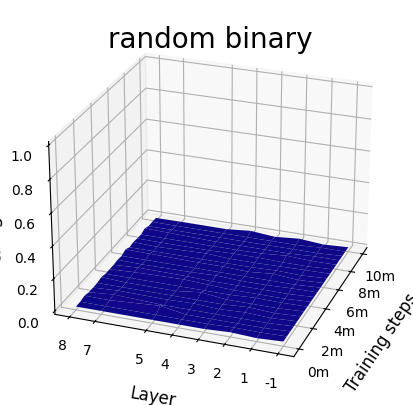

Loaded scores from evolution_-0.3475340320950463.pkl


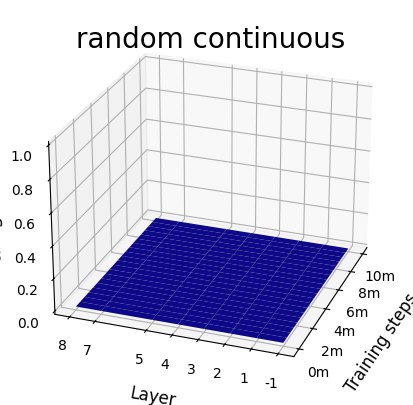

Loaded scores from evolution_0.8800880700822861.pkl


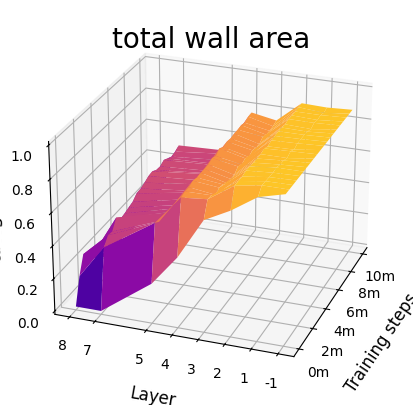

Loaded scores from evolution_-0.017857142857142856.pkl


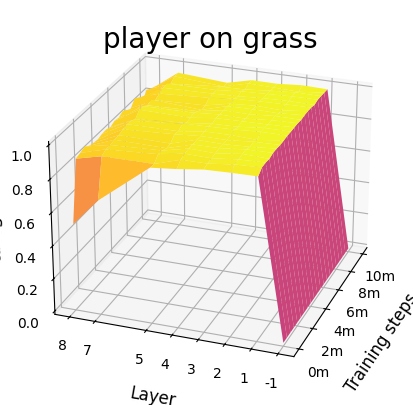

Loaded scores from evolution_0.871031746031746.pkl


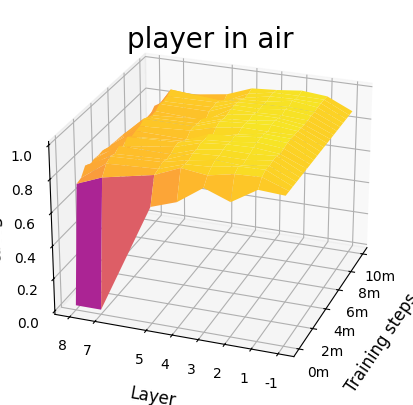

Loaded scores from evolution_0.05113636363636364.pkl


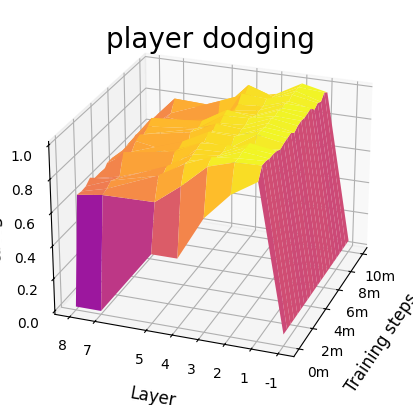

Loaded scores from evolution_0.013157894736842105.pkl


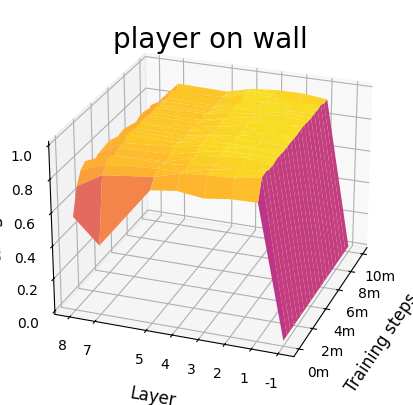

Loaded scores from evolution_-0.125.pkl


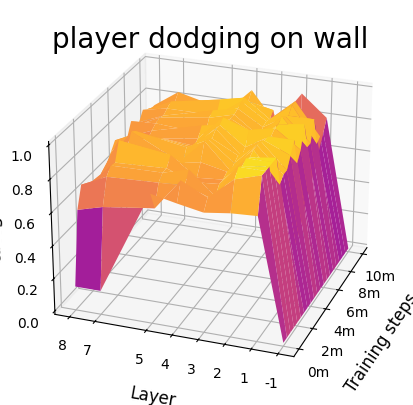

Loaded scores from evolution_0.6507890763736907.pkl


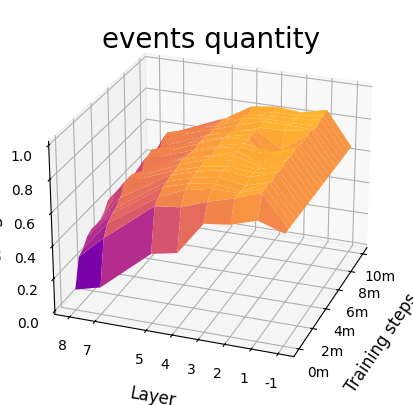

Loaded scores from evolution_-0.39020760854085285.pkl


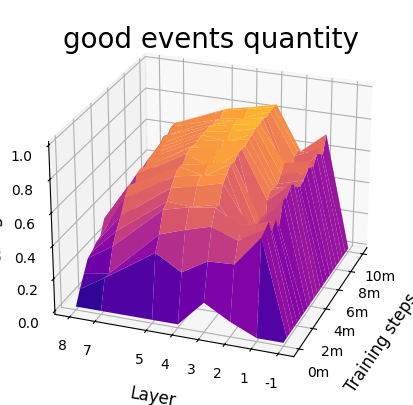

Loaded scores from evolution_0.6136526399188571.pkl


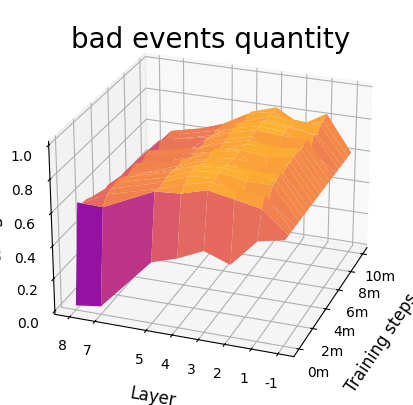

Loaded scores from evolution_0.007267441860465116.pkl


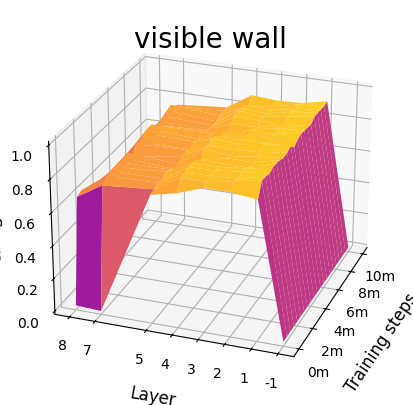

Loaded scores from evolution_-0.007936507936507936.pkl


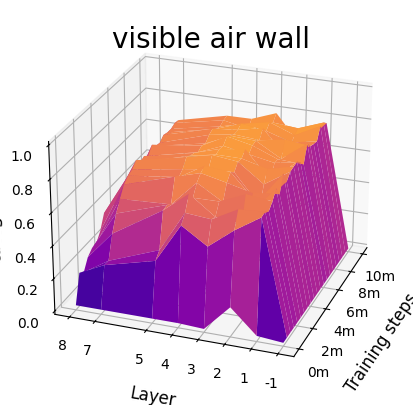

Loaded scores from evolution_0.007936507936507936.pkl


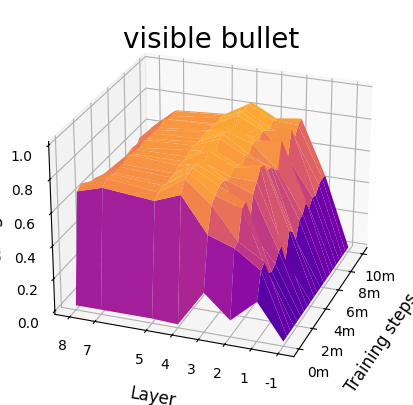

Loaded scores from evolution_-0.007936507936507936.pkl


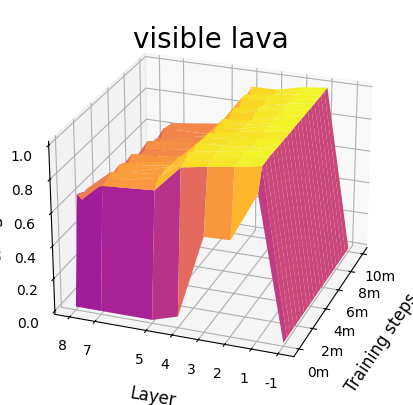

Loaded scores from evolution_0.007936507936507936.pkl


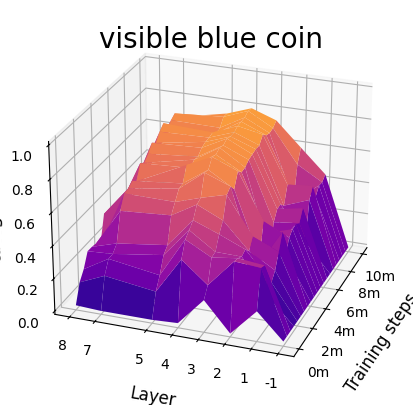

Loaded scores from evolution_-0.002976190476190476.pkl


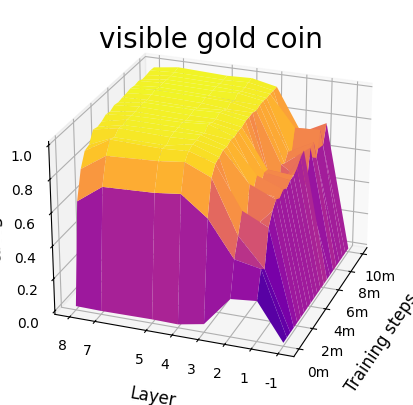

Loaded scores from evolution_-0.003289473684210526.pkl


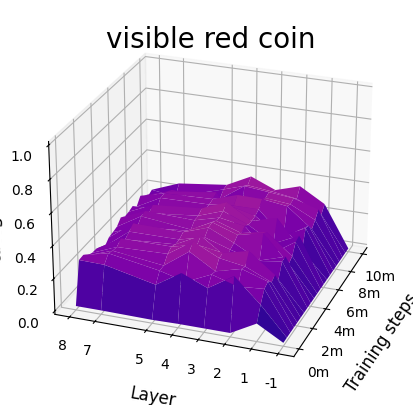

Loaded scores from evolution_-0.007936507936507936.pkl


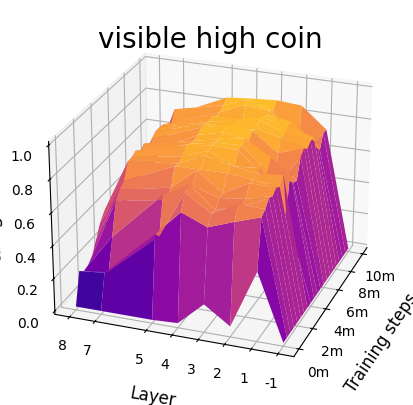

Loaded scores from evolution_-0.007936507936507936.pkl


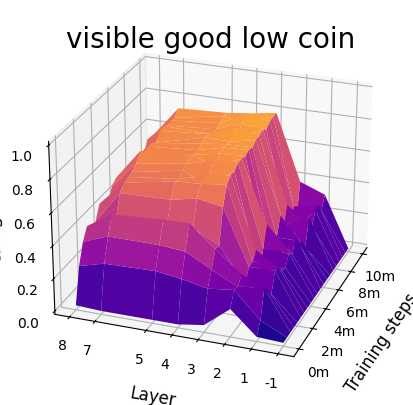

Loaded scores from evolution_0.349219006205362.pkl


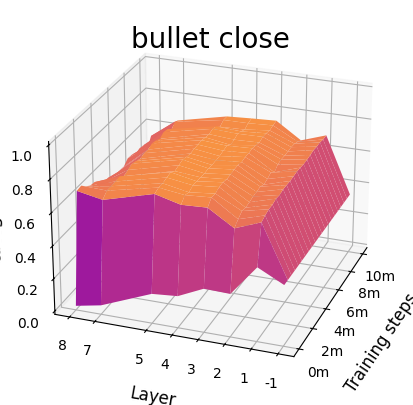

Loaded scores from evolution_0.0025.pkl


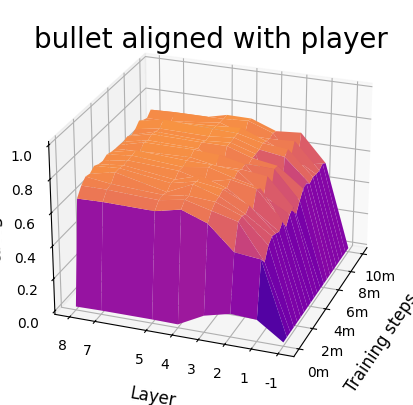

Loaded scores from evolution_-0.007936507936507936.pkl


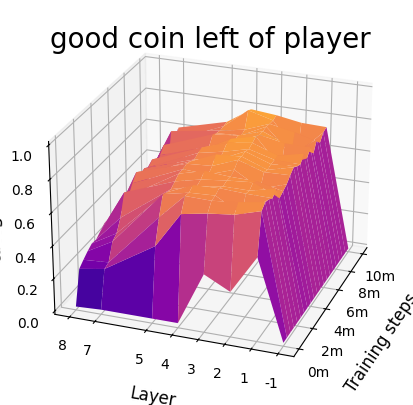

In [7]:
for concept in concept_instances.values():
    scores, input_score = get_scores(concept, models, [1, 2, 3, 4, 5, 7, 8], hyperparams, load=True)
    plot_evolution(concept, scores, input_score)

### Modified Env

Loaded model: 20240321-223500_task_0-0
Loaded model: 20240321-223500_task_0-250000
Loaded model: 20240321-223500_task_0-500000
Loaded model: 20240321-223500_task_0-750000
Loaded model: 20240321-223500_task_0-1000000
Loaded model: 20240321-223500_task_0-1250000
Loaded model: 20240321-223500_task_0-1500000
Loaded model: 20240321-223500_task_0-1750000
Loaded model: 20240321-223500_task_0-2000000
Loaded model: 20240321-223500_task_0-2250000
Loaded model: 20240321-223500_task_0-2500000
Loaded model: 20240321-223500_task_0-2750000
Loaded model: 20240321-223500_task_0-3000000
Loaded model: 20240321-223500_task_0-3250000
Loaded model: 20240321-223500_task_0-3500000
Loaded model: 20240321-223500_task_0-3750000
Loaded model: 20240321-223500_task_0-4000000
Loaded model: 20240321-223500_task_0-4250000
Loaded model: 20240321-223500_task_0-4500000
Loaded model: 20240321-223500_task_0-4750000
Loaded model: 20240321-223500_task_0-5000000


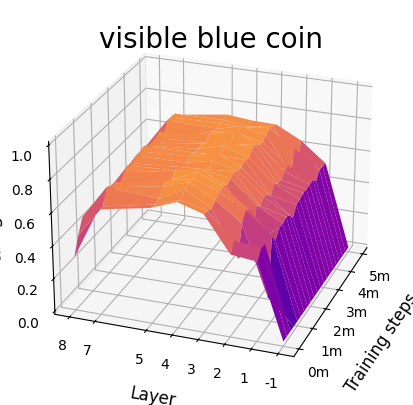

Loaded model: 20240321-223500_task_0-0
Loaded model: 20240321-223500_task_0-250000
Loaded model: 20240321-223500_task_0-500000
Loaded model: 20240321-223500_task_0-750000
Loaded model: 20240321-223500_task_0-1000000
Loaded model: 20240321-223500_task_0-1250000
Loaded model: 20240321-223500_task_0-1500000
Loaded model: 20240321-223500_task_0-1750000
Loaded model: 20240321-223500_task_0-2000000
Loaded model: 20240321-223500_task_0-2250000
Loaded model: 20240321-223500_task_0-2500000
Loaded model: 20240321-223500_task_0-2750000
Loaded model: 20240321-223500_task_0-3000000
Loaded model: 20240321-223500_task_0-3250000
Loaded model: 20240321-223500_task_0-3500000
Loaded model: 20240321-223500_task_0-3750000
Loaded model: 20240321-223500_task_0-4000000
Loaded model: 20240321-223500_task_0-4250000
Loaded model: 20240321-223500_task_0-4500000
Loaded model: 20240321-223500_task_0-4750000
Loaded model: 20240321-223500_task_0-5000000


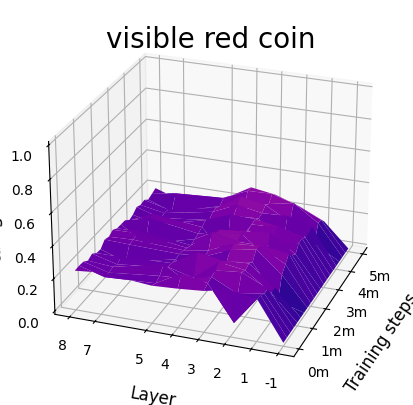

Loaded model: 20240321-223500_task_0-0
Loaded model: 20240321-223500_task_0-250000
Loaded model: 20240321-223500_task_0-500000
Loaded model: 20240321-223500_task_0-750000
Loaded model: 20240321-223500_task_0-1000000
Loaded model: 20240321-223500_task_0-1250000
Loaded model: 20240321-223500_task_0-1500000
Loaded model: 20240321-223500_task_0-1750000
Loaded model: 20240321-223500_task_0-2000000
Loaded model: 20240321-223500_task_0-2250000
Loaded model: 20240321-223500_task_0-2500000
Loaded model: 20240321-223500_task_0-2750000
Loaded model: 20240321-223500_task_0-3000000
Loaded model: 20240321-223500_task_0-3250000
Loaded model: 20240321-223500_task_0-3500000
Loaded model: 20240321-223500_task_0-3750000
Loaded model: 20240321-223500_task_0-4000000
Loaded model: 20240321-223500_task_0-4250000
Loaded model: 20240321-223500_task_0-4500000
Loaded model: 20240321-223500_task_0-4750000
Loaded model: 20240321-223500_task_0-5000000


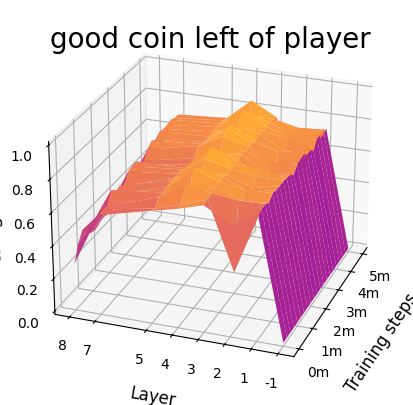

In [15]:
cool_concepts = ["good coin left of player", "visible red coin", "visible blue coin"]

model_path = 'runs/20240321-223500_task_0'
models = get_models(model_path)

for concept in concept_instances.values():
    if concept.name not in cool_concepts:
        continue
    scores, input_score = get_scores(concept, models, [1, 2, 3, 4, 5, 7, 8], hyperparams, load=False)
    plot_evolution(concept, scores, input_score)

### Modified & Original Env

Loaded model: 20240322-100656_task_0-0
Loaded model: 20240322-100656_task_0-250000
Loaded model: 20240322-100656_task_0-500000
Loaded model: 20240322-100656_task_0-750000
Loaded model: 20240322-100656_task_0-1000000
Loaded model: 20240322-100656_task_0-1250000
Loaded model: 20240322-100656_task_0-1500000
Loaded model: 20240322-100656_task_0-1750000
Loaded model: 20240322-100656_task_0-2000000
Loaded model: 20240322-100656_task_0-2250000
Loaded model: 20240322-100656_task_0-2500000
Loaded model: 20240322-100656_task_0-2750000
Loaded model: 20240322-100656_task_0-3000000
Loaded model: 20240322-100656_task_0-3250000
Loaded model: 20240322-100656_task_0-3500000
Loaded model: 20240322-100656_task_0-3750000
Loaded model: 20240322-100656_task_0-4000000
Loaded model: 20240322-100656_task_0-4250000
Loaded model: 20240322-100656_task_0-4500000
Loaded model: 20240322-100656_task_0-4750000
Loaded model: 20240322-100656_task_0-5000000


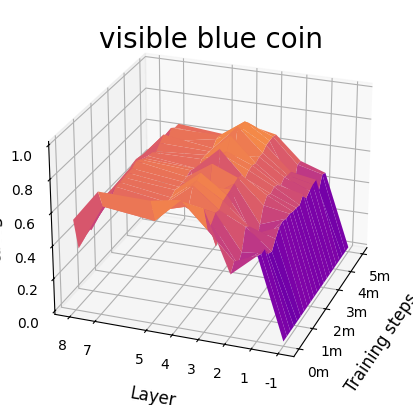

Loaded model: 20240322-100656_task_0-0
Loaded model: 20240322-100656_task_0-250000
Loaded model: 20240322-100656_task_0-500000
Loaded model: 20240322-100656_task_0-750000
Loaded model: 20240322-100656_task_0-1000000
Loaded model: 20240322-100656_task_0-1250000
Loaded model: 20240322-100656_task_0-1500000
Loaded model: 20240322-100656_task_0-1750000
Loaded model: 20240322-100656_task_0-2000000
Loaded model: 20240322-100656_task_0-2250000
Loaded model: 20240322-100656_task_0-2500000
Loaded model: 20240322-100656_task_0-2750000
Loaded model: 20240322-100656_task_0-3000000
Loaded model: 20240322-100656_task_0-3250000
Loaded model: 20240322-100656_task_0-3500000
Loaded model: 20240322-100656_task_0-3750000
Loaded model: 20240322-100656_task_0-4000000
Loaded model: 20240322-100656_task_0-4250000
Loaded model: 20240322-100656_task_0-4500000
Loaded model: 20240322-100656_task_0-4750000
Loaded model: 20240322-100656_task_0-5000000


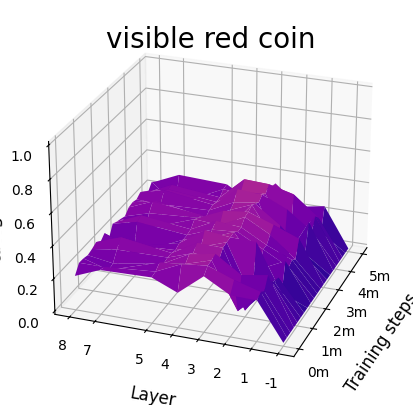

Loaded model: 20240322-100656_task_0-0
Loaded model: 20240322-100656_task_0-250000
Loaded model: 20240322-100656_task_0-500000
Loaded model: 20240322-100656_task_0-750000
Loaded model: 20240322-100656_task_0-1000000
Loaded model: 20240322-100656_task_0-1250000
Loaded model: 20240322-100656_task_0-1500000
Loaded model: 20240322-100656_task_0-1750000
Loaded model: 20240322-100656_task_0-2000000
Loaded model: 20240322-100656_task_0-2250000
Loaded model: 20240322-100656_task_0-2500000
Loaded model: 20240322-100656_task_0-2750000
Loaded model: 20240322-100656_task_0-3000000
Loaded model: 20240322-100656_task_0-3250000
Loaded model: 20240322-100656_task_0-3500000
Loaded model: 20240322-100656_task_0-3750000
Loaded model: 20240322-100656_task_0-4000000
Loaded model: 20240322-100656_task_0-4250000
Loaded model: 20240322-100656_task_0-4500000
Loaded model: 20240322-100656_task_0-4750000
Loaded model: 20240322-100656_task_0-5000000


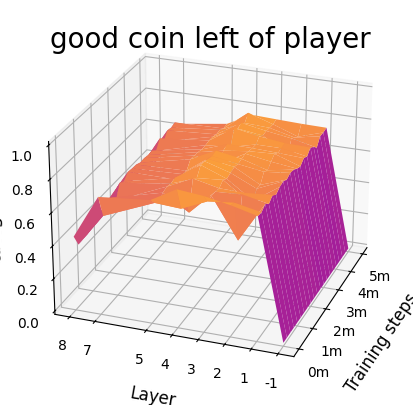

In [17]:
model_path = 'runs/20240322-100656_task_0'
models = get_models(model_path)

for concept in concept_instances.values():
    if concept.name not in cool_concepts:
        continue
    scores, input_score = get_scores(concept, models, [1, 2, 3, 4, 5, 7, 8], hyperparams, load=False)
    plot_evolution(concept, scores, input_score)